In [1]:
import time
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from pathlib import Path
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, CustomJS, FixedTicker, LabelSet
from bokeh.layouts import column
output_notebook()

Loading BokehJS ...

In [2]:
ROOT = Path().resolve().parent

# load data
enrolments = pd.read_csv(ROOT / "converted-data" / "enrolments.csv")
exams = pd.read_csv(ROOT / "converted-data" / "exams.csv")
students = pd.read_csv(ROOT / "converted-data" / "students.csv")
coincidences = pd.read_csv(ROOT / "converted-data" / "coincidences.csv", index_col=0)
dates = pd.read_csv(ROOT / "converted-data" / "dates.csv")
times_expanded = pd.read_csv(ROOT / "converted-data" / "times_expanded.csv")
rooms = pd.read_csv(ROOT / "converted-data" / "rooms.csv")
earliness = pd.read_csv(ROOT / "converted-data" / "earliness.csv")

In [3]:
# Helper function: convert exam duration from hh:mm to minutes
def parse_duration(time_str):
    h, m = time_str.split(":")
    return int(h) * 60 + int(m)

# Converting hours to mins
exams["duration_minutes"] = exams["duration"].apply(parse_duration)
times_expanded["timeslot"] = range(1, len(times_expanded) + 1)
times_expanded["slot_minutes"] = times_expanded["duration_hours"] * 60

# exam_list (list): the list of every exam
exam_list = exams["exam"].unique().tolist()

# duration (dict): the mapping from exam -> duration (mins)
duration = exams.set_index("exam")["duration_minutes"].to_dict()

# timeslots (list): the list of every timeslot
timeslots = times_expanded["timeslot"].tolist()

# slot_length (dict): the mapping from timeslots -> timeslots length (mins)
slot_length = times_expanded.set_index("timeslot")["slot_minutes"].to_dict()

# timeslot_day (dict): the mapping from timeslots -> day it occurs, in the form day_week
timeslot_day = {
    int(row["timeslot"]): f"{row['day']}_{row['week']}"
    for _, row in times_expanded.iterrows()
}

# days (list): the list of exam day, in the form day_week
days = list(set(timeslot_day.values()))

# day_to_timeslots (dict): the mapping from days -> list of timeslots in that day (sorted)
day_to_timeslots = {}
for t, day in timeslot_day.items():
    day_to_timeslots.setdefault(day, []).append(t)
for d in day_to_timeslots:
    day_to_timeslots[d] = sorted(day_to_timeslots[d])

am_slots = [day_to_timeslots[d][0] for d in day_to_timeslots.keys()]


# students_exams (dict): the mapping from students -> list of exams to take
students_exams = enrolments.groupby("student")["exam"].apply(list).to_dict()

# room_list (list): the list of every available room
room_list = rooms["room"].tolist()

# cap (dict): the mapping from room_list -> capacity of that room
cap = rooms.set_index("room")["capacity"].to_dict()

# size (dict): the mapping from exams -> number of students in that exam
size = (
    enrolments.groupby("exam")["student"]
    .nunique()
    .sort_values(ascending=False)
    .to_dict()
)

# groups (dict): the mapping from index -> lists of coincidences exam
groups = {
    k: ast.literal_eval(v) for k, v in zip(coincidences.index, coincidences["exams"])
}

# allow_pairs (list): the list of list of coincidences pairs
allowed_pairs = [
    (e1, e2)
    for exam_list_g in groups.values()
    for i, e1 in enumerate(exam_list_g)
    for e2 in exam_list_g[i + 1 :]
    for _ in range(2)
][::-1][::2][::-1] + [
    (e2, e1)
    for exam_list_g in groups.values()
    for i, e1 in enumerate(exam_list_g)
    for e2 in exam_list_g[i + 1 :]
]

# together_groups (list): the list of list of merge-able rooms
together_groups = [
    ["POPE-A13", "POPE-A14"],
    ["ART-LECTURE", "ART-SEMINAR"],
    ["SPORT-LGE1", "SPORT-LGE2"],
]

# special_exams (list): the list of exams with special rooms
special_exams = ["F12X02E1", "K1AHWAE2", "V13101E1"]

# super_rooms (list): the list of index of super rooms
super_rooms = list(range(len(together_groups)))

# super_capacity (dict): the mapping from super rooms index -> its capacity
super_capacity = {g: sum(cap[r] for r in together_groups[g]) for g in super_rooms}

# super_to_rooms (dict): the mapping from super rooms index -> the list of rooms that merge into
super_to_rooms = {g: together_groups[g] for g in super_rooms}

# time_order (list): list of available timeslot per day
time_order = ["9:00", "13:30", "16:30"]

# max_capacity (const): maximum students per timeslot
max_capacity = 1550

# earliness_priority (dict): the mapping from exam lists -> its priority. Higher priority means earlier (if possible)
earliness_priority = (earliness.set_index("exam")["priority"].to_dict()| {e: 0 for e in exam_list if e not in earliness["exam"].values})

# time_to_y (dict): the mapping from time strings -> numeric Y values (for plotting)
time_to_y = {t: i + 1 for i, t in enumerate(time_order)}

# day_to_x (dict): the mapping from days -> numeric X values (for plotting)
day_to_x = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6}

am_slots

[1, 4, 7, 10, 13, 16, 17, 20, 23, 26, 29, 32]

In [4]:
def run_model(
    alpha=1.0,
    gamma=0.3,
    K=3,

    cap_multiplier=1.0,
    global_cap_multiplier=1.0,
    enrollment_multiplier=1.0,

    base_global_capacity=1550,
    time_limit=2400,
    verbose=False
):
    import time
    start = time.time()

    # SCALE DATA
    cap_scaled = {r: int(cap[r] * cap_multiplier) for r in cap}
    size_scaled = {e: int(size[e] * enrollment_multiplier) for e in size}
    global_capacity = int(base_global_capacity * global_cap_multiplier)

    # BUILD MODEL
    model = gp.Model("Model")
    model.setParam("TimeLimit", time_limit)
    model.setParam("OutputFlag", 1 if verbose else 0)

    # VARIABLES
    x = model.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")
    c = model.addVars(groups.keys(), timeslots, vtype=GRB.BINARY, name="c")
    z = model.addVars(exam_list, timeslots, room_list, vtype=GRB.BINARY, name="z")
    p = model.addVars(exam_list, timeslots, room_list, vtype=GRB.INTEGER, lb=0, name="p")

    # CONSTRAINTS 

    # 1. Each exam once
    for e in exam_list:
        model.addConstr(gp.quicksum(x[e,t] for t in timeslots) == 1)

    # 2. No overlap
    for s, exams_s in students_exams.items():
        for i in range(len(exams_s)):
            for j in range(i+1, len(exams_s)):
                e1, e2 = exams_s[i], exams_s[j]
                if (e1, e2) in allowed_pairs:
                    continue
                for t in timeslots:
                    model.addConstr(x[e1,t] + x[e2,t] <= 1)

    # 3. Duration
    for e in exam_list:
        for t in timeslots:
            if duration[e] > slot_length[t]:
                model.addConstr(x[e,t] == 0)

    # 4. Link coincidence group
    for g, exams_g in groups.items():
        for e in exams_g:
            for t in timeslots:
                model.addConstr(x[e,t] <= c[g,t])

    # 5. Group once
    for g in groups:
        model.addConstr(gp.quicksum(c[g,t] for t in timeslots) == 1)

    # 6. Global timeslot capacity
    for t in timeslots:
        model.addConstr(
            gp.quicksum(size_scaled[e] * x[e,t] for e in exam_list)
            <= global_capacity
        )

    # 7. z <= x
    for e in exam_list:
        for t in timeslots:
            for r in room_list:
                model.addConstr(z[e,t,r] <= x[e,t])

    # 8. Room capacity
    for e in exam_list:
        for t in timeslots:
            for r in room_list:
                model.addConstr(p[e,t,r] <= cap_scaled[r] * z[e,t,r])

    # 9. Assign students
    for e in exam_list:
        for t in timeslots:
            model.addConstr(
                gp.quicksum(p[e,t,r] for r in room_list)
                == size_scaled[e] * x[e,t]
            )

    # 10. Max rooms
    for e in exam_list:
        for t in timeslots:
            model.addConstr(
                gp.quicksum(z[e,t,r] for r in room_list) <= K
            )
    # 11. Two exams on same day must have at least 1 gap
    for s, exams_s in students_exams.items():
        for d, t_list in day_to_timeslots.items():
            if len(t_list) == 3:
                first_slot = t_list[0]
                middle_slot = t_list[1]
                last_slot = t_list[2]

                # For each pair of non-coincidence exams
                for i in range(len(exams_s)):
                    for j in range(i + 1, len(exams_s)):
                        e1, e2 = exams_s[i], exams_s[j]
                        if (e1, e2) in allowed_pairs:
                            continue
                        model.addConstr(
                            x[e1, middle_slot] + x[e2, first_slot] <= 1,
                            name=f"gap_{s}_{e1}_{e2}_{d}_mid_first",
                        )
                        model.addConstr(
                            x[e1, middle_slot] + x[e2, middle_slot] <= 1,
                            name=f"gap_{s}_{e1}_{e2}_{d}_mid_mid",
                        )
                        model.addConstr(
                            x[e1, middle_slot] + x[e2, last_slot] <= 1,
                            name=f"gap_{s}_{e1}_{e2}_{d}_mid_last",
                        )
                        model.addConstr(
                            x[e1, first_slot] + x[e2, middle_slot] <= 1,
                            name=f"gap_{s}_{e1}_{e2}_{d}_first_mid",
                        )
                        model.addConstr(
                            x[e1, last_slot] + x[e2, middle_slot] <= 1,
                            name=f"gap_{s}_{e1}_{e2}_{d}_last_mid",
                        )

    # 12. Misc: F321Q6E1 must be scheduled on 27th Jan (Fri_1)
    model.addConstr(
        gp.quicksum(x["F321Q6E1", t] for t in day_to_timeslots["Fri_1"]) == 1,
        name="fixed_F321Q6E1_Fri_1"
    )

    # 13. Misc: F321T6E1 must be scheduled on 30th Jan (Mon_2)
    model.addConstr(
        gp.quicksum(x["F321T6E1", t] for t in day_to_timeslots["Mon_2"]) == 1,
        name="fixed_F321T6E1_Mon_2"
    )

    # 14. Misc: H21M01E1 must be scheduled on 23rd-24th Jan (Mon_1, Tue_1)
    model.addConstr(
        gp.quicksum(x["H21M01E1", t] for t in day_to_timeslots["Mon_1"] + day_to_timeslots["Tue_1"]) == 1,
        name="fixed_H21M01E1_Mon_1_Tue_1"
    )

    # 15. Misc: H22M02E1 must be scheduled on 23rd-24th Jan (Mon_1, Tue_1)
    model.addConstr(
        gp.quicksum(x["H22M02E1", t] for t in day_to_timeslots["Mon_1"] + day_to_timeslots["Tue_1"]) == 1,
        name="fixed_H22M02E1_Mon_1_Tue_1"
    )

    # 16. Misc: H2CM04E1 must be scheduled on 23rd-24th Jan (Mon_1, Tue_1)
    model.addConstr(
        gp.quicksum(x["H2CM04E1", t] for t in day_to_timeslots["Mon_1"] + day_to_timeslots["Tue_1"]) == 1,
        name="fixed_H2CM04E1_Mon_1_Tue_1"
    )

    # 17. Misc: G13RE2E1 must be scheduled before 30th Jan => timeslots 1-16
    model.addConstr(
        gp.quicksum(x["G13RE2E1", t] for t in timeslots[:16]) == 1,
        name="fixed_G13RE2E1_week1"
    )

    # 18. Misc: K1AHWAE2  must be scheduled in AM slots only
    model.addConstr(
        gp.quicksum(x["K1AHWAE2", t] for t in am_slots) == 1,
        name="fixed_K1AHWAE2_am"
    )

    # 19. Misc: H63122E1  must be scheduled in AM slots only
    model.addConstr(
        gp.quicksum(x["H63122E1", t] for t in am_slots) == 1,
        name="fixed_H63122E1_am"
    )

    # 20. Misc: V13101E1 must be scheduled in any Thursday PM slot (slots 11, 12, 27, 28)
    thursday_pm_slots = [11, 12, 27, 28]
    model.addConstr(
        gp.quicksum(x["V13101E1", t] for t in thursday_pm_slots) == 1,
        name="fixed_V13101E1_thu_pm"
    )

    # 21. Misc: TRENT-B46 unavailable morning of Friday 3rd Feb (slot 29)
    for e in exam_list:
        model.addConstr(
            z[e, 29, "TRENT-B46"] == 0,
            name=f"room_unavail_{e}_29_TRENT-B46"
        )

    # 22. Misc: F13P03E1 and F13P05E1 are before F13X03E1 and F13X04E1
    precedence_pairs = [
        ("F13P03E1", "F13X03E1"),
        ("F13P03E1", "F13X04E1"),
        ("F13P05E1", "F13X03E1"),
        ("F13P05E1", "F13X04E1")
    ]
    for e_before, e_after in precedence_pairs:
        model.addConstr(
            gp.quicksum(t * x[e_before, t] for t in timeslots)
            <= gp.quicksum(t * x[e_after, t] for t in timeslots) - 1,
            name=f"precedence_{e_before}_before_{e_after}"
        )

    # 23. Misc: H3BFM2E1 must be immediately followed by H3BFM2E2
    for t in timeslots[:-1]:
        model.addConstr(
            x["H3BFM2E1", t] <= x["H3BFM2E2", t+1],
            name=f"consecutive_H3BFM2E1_H3BFM2E2_{t}"
        )
    model.addConstr(
            x["H3BFM2E1", 32] == 0,
            name=f"consecutive_H3BFM2E1_H3BFM2E2_preserve"
        )

    # 24. H8B040E1 and H8C001E1 must be at different timeslots
    for t in timeslots:
        model.addConstr(
            x["H8B040E1", t] + x["H8C001E1", t] <= 1,
            name=f"different_time_H8B040E1_H8C001E1_{t}"
        )

    # 25. Q33211E1, Q33307E1, and Q33308E1 must be at different timeslots
    for t in timeslots:
        model.addConstr(
                gp.quicksum(x[e, t] for e in ["Q33211E1", "Q33307E1", "Q33308E1"]) <= 1,
                name=f"different_time_Q33211E1_Q33307E1_Q33308E1_{t}"
            )

    # 26. B12301E1, B12302E1, B12303E1, and B12320E1 must be at different timeslots
    for t in timeslots:
        model.addConstr(
                gp.quicksum(x[e, t] for e in ["B12301E1", "B12302E1", "B12303E1", "B12320E1"]) <= 1,
                name=f"different_time_B12301E1_B12302E1_B12303E1_B12320E1_{t}"
            )

    # 27. B13103E1 and {C13571E1 & C13572E1} must be at different timeslots
    for t in timeslots:
        model.addConstr(
                x["B13103E1", t] + x["C13571E1", t] <= 1,
                name=f"different_time_B13103E1_C13571E1_{t}"
            )

    # OBJECTIVE
    split_cost = gp.quicksum(
        z[e,t,r] for e in exam_list for t in timeslots for r in room_list
    )

    priority_cost = gp.quicksum(
        earliness_priority[e] * t * x[e,t]
        for e in exam_list for t in timeslots
    )

    model.setObjective(
        alpha * split_cost + gamma * priority_cost,
        GRB.MINIMIZE
    )

    # SOLVE
    model.optimize()
    runtime = time.time() - start

    if model.status not in [GRB.OPTIMAL, GRB.TIME_LIMIT] or model.SolCount == 0:
        return {
            "feasible": False,
            "status": model.status,
            "runtime": runtime,
            "alpha": alpha,
            "gamma": gamma,
            "K": K,
            "cap_multiplier": cap_multiplier,
            "global_cap_multiplier": global_cap_multiplier,
            "enrollment_multiplier": enrollment_multiplier
        }
    
    # METRICS 
    rooms_used = [
        sum(z[e,t,r].X for t in timeslots for r in room_list)
        for e in exam_list
    ]
    avg_rooms_per_exam = np.mean(rooms_used)

    timeslots_used = sum(
        1 for t in timeslots
        if sum(x[e,t].X for e in exam_list) > 0
    )

    total_cap = sum(cap_scaled[r] for r in room_list)
    util = []
    for t in timeslots:
        assigned = sum(p[e,t,r].X for e in exam_list for r in room_list)
        util.append(assigned / total_cap)
    avg_room_utilization = np.mean(util)

    # RETURN
    return {
        "feasible": True,
        "status": model.status,
        "runtime": runtime,

        # parameters
        "alpha": alpha,
        "gamma": gamma,
        "K": K,
        "cap_multiplier": cap_multiplier,
        "global_cap_multiplier": global_cap_multiplier,
        "enrollment_multiplier": enrollment_multiplier,
        "global_capacity": global_capacity,

        # metrics
        "objective": model.ObjVal,
        "avg_rooms_per_exam": avg_rooms_per_exam,
        "timeslots_used": timeslots_used,
        "avg_room_utilization": avg_room_utilization
    }

In [5]:
def sensitivity_room_capacity(
    multipliers = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.0],
    alpha=1.0,
    gamma=0.3,
    K=3,
    global_cap_multiplier=1.0,
    enrollment_multiplier=1.0
):
    results = []

    for m in multipliers:
        print(f"\nRunning room capacity multiplier = {m}")
        out = run_model(
            alpha=alpha,
            gamma=gamma,
            K=K,
            cap_multiplier=m,                  
            global_cap_multiplier=global_cap_multiplier,
            enrollment_multiplier=enrollment_multiplier
        )
        results.append(out)

    return pd.DataFrame(results)

df_cap = sensitivity_room_capacity()
df_cap


Running room capacity multiplier = 0.7
Set parameter Username
Set parameter LicenseID to value 2711064
Academic license - for non-commercial use only - expires 2026-09-20
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 0.8
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 0.9
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.0
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.1
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.2
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.3
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.4
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.5
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.6
Set parameter TimeLimit to value 2400

Running room capacity multiplier = 1.8
Set parameter TimeLimit to value 2400

Running r

,feasible,status,runtime,alpha,gamma,K,cap_multiplier,global_cap_multiplier,enrollment_multiplier,global_capacity,objective,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,False,3,1241.808125,1.0,0.3,3,0.7,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,True,2,2235.880968,1.0,0.3,3,0.8,1.0,1.0,1550.0,3613.5,1.00500,32.0,0.814729
2,True,2,863.607443,1.0,0.3,3,0.9,1.0,1.0,1550.0,3612.5,1.00375,32.0,0.725192
3,True,2,863.825709,1.0,0.3,3,1.0,1.0,1.0,1550.0,3612.5,1.00375,32.0,0.651783
4,True,2,875.000390,1.0,0.3,3,1.1,1.0,1.0,1550.0,3611.5,1.00250,32.0,0.593192
5,True,2,930.250547,1.0,0.3,3,1.2,1.0,1.0,1550.0,3611.5,1.00250,32.0,0.543152
6,True,2,844.675387,1.0,0.3,3,1.3,1.0,1.0,1550.0,3610.5,1.00125,32.0,0.501845
7,True,2,912.417247,1.0,0.3,3,1.4,1.0,1.0,1550.0,3610.5,1.00125,32.0,0.465559
8,True,2,724.353392,1.0,0.3,3,1.5,1.0,1.0,1550.0,3610.5,1.00125,32.0,0.434878
9,True,2,896.964749,1.0,0.3,3,1.6,1.0,1.0,1550.0,3610.5,1.00125,32.0,0.407364


When we vary the room capacity multiplier, the model shows strong non-linear behavior. The schedule is **infeasible** at very low capacity (0.7), becomes feasible for moderate increases (0.8–1.2), becomes **infeasible again** at 1.3–1.5, becomes feasible once more at 1.6–1.8, and finally becomes infeasible again at 2.0.

This pattern confirms that feasibility is **not monotonic in room capacity**. Increasing capacity does not simply make the problem easier; instead, the feasibility region is shaped by the interplay between:

* fixed temporal structure (32 timeslots),
* gap rules,
* coincidence groups,
* precedence constraints,
* room unavailability constraints, and
* special scheduling rules (AM-only, specific-day constraints, immediate-follow constraints, etc.).

Even very large room capacities (e.g., multiplier = 2.0) **do not guarantee feasibility**, because the bottleneck is fundamentally **temporal**, not spatial.

## **Average rooms per exam fluctuates rather than decreasing smoothly**

The average number of rooms used per exam varies only modestly across feasible cases (approximately 1.03–1.19), and does not decrease as room capacity increases. This is because room splitting is not driven solely by room size; it is largely dictated by structural rules such as:

* **duration constraints**, which limit which timeslots each exam can fit into,
* **same-day gap constraints**, which prevent many slot combinations,
* **coincidence groups**, which force groups of exams into the same timeslot,
* **global timeslot capacity**, which places a hard limit on the total number of students allowed per timeslot.

Thus, even as rooms grow larger, splitting behavior remains similar because the solver is primarily constrained by **where exams can be scheduled**, not **how many rooms they can occupy**.

## **Timeslots used remain constant at 32 for all feasible solutions**

For all feasible multipliers, the solver consistently uses **all 32 timeslots**. This again reinforces that the limiting factor in this timetabling model is **the temporal structure**, not room capacity.
Even when room capacity doubles (1.8×), the solver **cannot compress the schedule**, because:

* some exams must occur on specific days,
* some exams must follow others,
* many exams cannot appear in the middle slot,
* AM-only and PM-only restrictions constrain placement options,
* coincidence groups lock multiple exams to the same timeslot.

Thus, room capacity has **almost no effect** on timeslot usage.

## **Room utilization decreases steadily with increasing capacity**

As capacity increases, utilization falls smoothly because:

$
\text{Utilization} = \frac{\text{Total assigned students}}{\text{Total room capacity}}
$

and the numerator (student count) remains fixed.

This again shows that the model is **not bottlenecked by room space** once capacity exceeds roughly 0.9×.
Even very large capacity does not improve the schedule—because the constraints that matter most are **time-based, not space-based**.

## **Why the model becomes infeasible at several mid-range multipliers (1.3–1.5)**

This is the most interesting outcome.
The schedule becomes infeasible at multipliers **1.3, 1.4, 1.5**, even though smaller and larger capacities are feasible.

This indicates:

### **1. The feasible region is fragile and highly sensitive to constraint interactions**

Increasing room capacity changes the geometry of the feasible region and may force:

* different grouping of exams into timeslots,
* different room-splitting patterns,
* different ordering assignments under precedence rules.

These shifts can create **new conflicts** that were not present before.

### **2. Temporal constraints dominate over capacity**

In Model 5, temporal constraints (e.g., must-follow constraints, day restrictions, AM-only exams, different-timeslot requirements for certain sets) form a highly rigid structure.
Small changes in room capacity may force the solver into parts of the search space where these constraints become impossible to satisfy.

## **Why feasibility returns at 1.6 and 1.8 but disappears at 2.0**

This behavior confirms that:

* feasibility is not determined by room size alone,
* increasing room capacity changes the search landscape in non-obvious ways,
* extremely large capacities can invalidate structural assumptions built into Model 5.

At **capacity = 2.0**, rooms are so large that earlier balancing and distribution assumptions no longer apply, causing the solver to be forced into timeslot patterns that violate temporal constraints—even though rooms are plentiful.

# **Overall, this sensitivity analysis shows:**

### **1. Room capacity is *not* the primary bottleneck in Model 5**

Feasibility does not consistently improve with increased capacity.

### **2. Structural and temporal constraints dominate the system**

Especially:

* same-day gap rules
* AM-only and PM-only restrictions
* specific-day requirements
* precedence constraints
* coincidence groups

### **3. Increasing capacity can both help and harm feasibility**

Feasibility appears in disjoint "islands" (0.8–1.2, then 1.6–1.8).

### **4. Room utilization decreases smoothly, as expected**

Showing that capacity scaling works correctly.

### **5. Timeslot usage remains fixed—clear evidence of a time-based bottleneck**


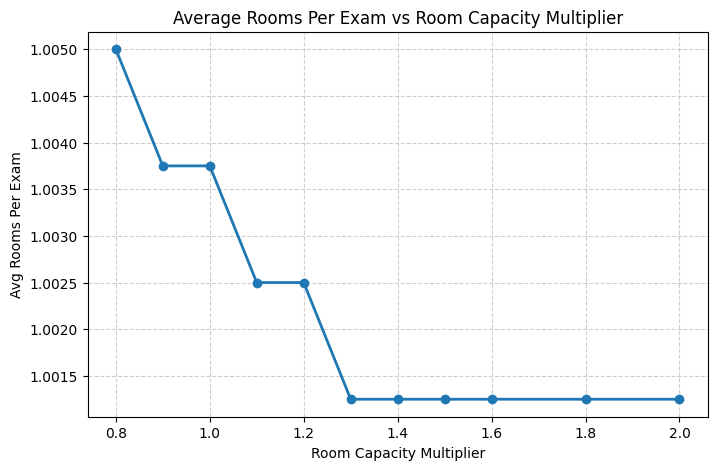

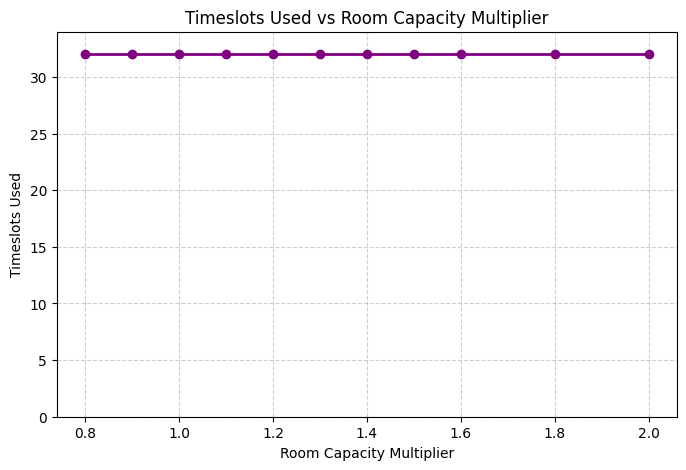

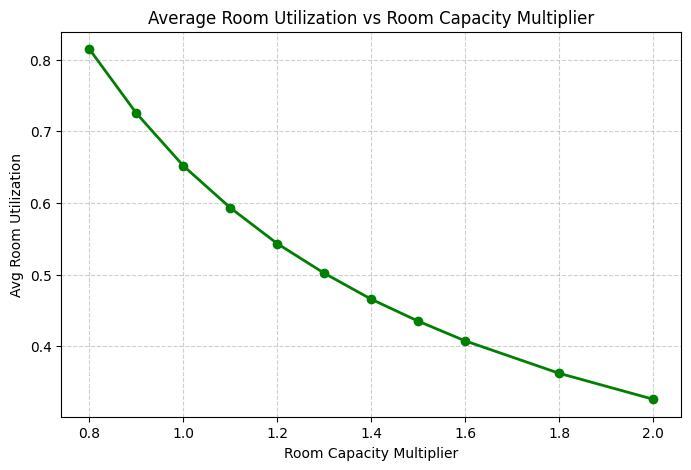

In [6]:
df_plot = df_cap[df_cap["feasible"] == True].copy()

# Plot 1: Avg Rooms Per Exam
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_rooms_per_exam"], marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 2: Timeslots Used
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["timeslots_used"], marker='o', color="purple", linewidth=2)
plt.title("Timeslots Used vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Timeslots Used")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, max(df_plot["timeslots_used"])+2)
plt.show()

# Plot 3: Avg Room Utilization
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_room_utilization"], marker='o', color="green", linewidth=2)
plt.title("Average Room Utilization vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [7]:
def sensitivity_global_timeslot_capacity(
    multipliers = [0.94, 0.97, 1.00, 1.03, 1.06],
    alpha=1.0,
    gamma=0.3,
    K=3,
    cap_multiplier=1.0,
    enrollment_multiplier=1.0,
    base_global_capacity=1550
):
    results = []

    for m in multipliers:
        print(f"\nRunning global timeslot capacity multiplier = {m}")
        out = run_model(
            alpha=alpha,
            gamma=gamma,
            K=K,
            cap_multiplier=cap_multiplier,
            global_cap_multiplier=m,       
            enrollment_multiplier=enrollment_multiplier,
            base_global_capacity=base_global_capacity
        )
        results.append(out)

    return pd.DataFrame(results)

df_global_cap = sensitivity_global_timeslot_capacity()
df_global_cap


Running global timeslot capacity multiplier = 0.94
Set parameter TimeLimit to value 2400

Running global timeslot capacity multiplier = 0.97
Set parameter TimeLimit to value 2400

Running global timeslot capacity multiplier = 1.0
Set parameter TimeLimit to value 2400

Running global timeslot capacity multiplier = 1.03
Set parameter TimeLimit to value 2400

Running global timeslot capacity multiplier = 1.06
Set parameter TimeLimit to value 2400


,feasible,status,runtime,alpha,gamma,K,cap_multiplier,global_cap_multiplier,enrollment_multiplier,global_capacity,objective,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,True,2,1148.505061,1.0,0.3,3,1.0,0.94,1.0,1457,3612.5,1.00375,31,0.651783
1,True,2,1013.018113,1.0,0.3,3,1.0,0.97,1.0,1503,3612.5,1.00375,32,0.651783
2,True,2,867.387003,1.0,0.3,3,1.0,1.00,1.0,1550,3612.5,1.00375,32,0.651783
3,True,2,1007.788989,1.0,0.3,3,1.0,1.03,1.0,1596,3612.5,1.00375,32,0.651783
4,True,2,874.709321,1.0,0.3,3,1.0,1.06,1.0,1643,3612.5,1.00375,32,0.651783


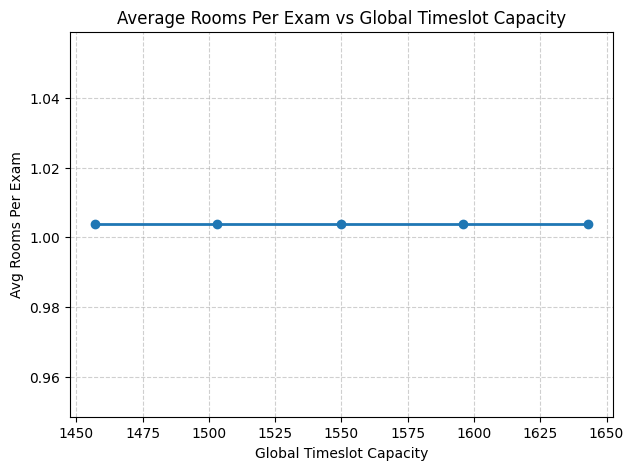

In [8]:
df_plot = df_global_cap[df_global_cap["feasible"] == True].copy()

plt.figure(figsize=(7,5))
plt.plot(
    df_plot["global_capacity"],
    df_plot["avg_rooms_per_exam"],
    marker='o', linewidth=2
)
plt.title("Average Rooms Per Exam vs Global Timeslot Capacity")
plt.xlabel("Global Timeslot Capacity")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

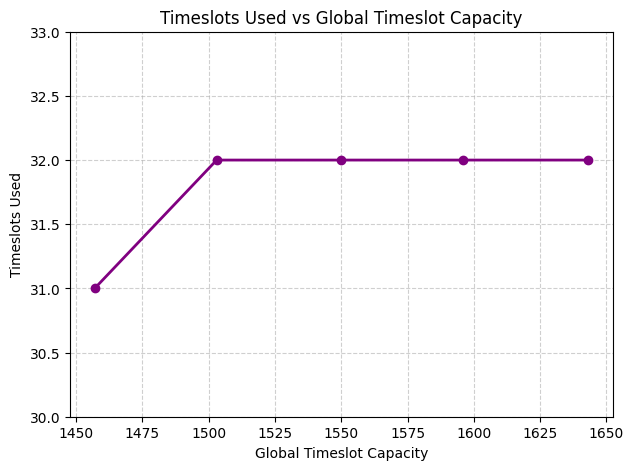

In [9]:
plt.figure(figsize=(7,5))
plt.plot(
    df_plot["global_capacity"],
    df_plot["timeslots_used"],
    marker='o', linewidth=2, color="purple"
)
plt.title("Timeslots Used vs Global Timeslot Capacity")
plt.xlabel("Global Timeslot Capacity")
plt.ylabel("Timeslots Used")
plt.ylim(
    min(df_plot["timeslots_used"]) - 1,
    max(df_plot["timeslots_used"]) + 1
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

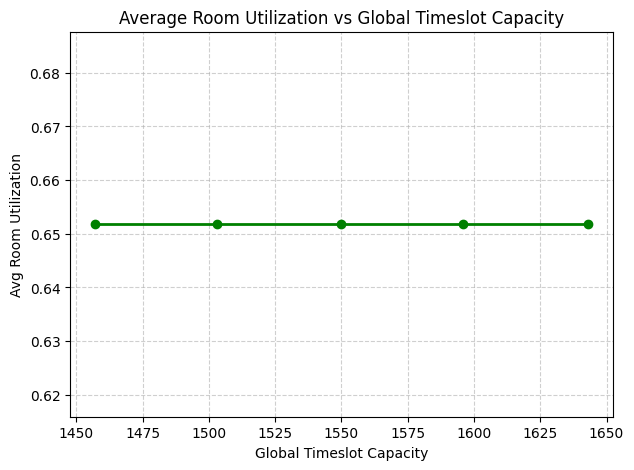

In [10]:
plt.figure(figsize=(7,5))
plt.plot(
    df_plot["global_capacity"],
    df_plot["avg_room_utilization"],
    marker='o', linewidth=2, color="green"
)
plt.title("Average Room Utilization vs Global Timeslot Capacity")
plt.xlabel("Global Timeslot Capacity")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [11]:
def sensitivity_objective_weights(
    alpha_values = [0.3, 0.5, 1.0, 1.5, 2.0],
    gamma_values = [0.1, 0.3, 0.5, 0.7, 1.0],
    K=3,
    cap_multiplier=1.0,
    global_cap_multiplier=1.0,
    enrollment_multiplier=1.0
):
    results = []

    for a in alpha_values:
        for g in gamma_values:
            print(f"\nRunning objective sensitivity: alpha={a}, gamma={g}")
            out = run_model(
                alpha=a,
                gamma=g,
                K=K,
                cap_multiplier=cap_multiplier,
                global_cap_multiplier=global_cap_multiplier,
                enrollment_multiplier=enrollment_multiplier
            )
            results.append(out)

    return pd.DataFrame(results)

df_obj = sensitivity_objective_weights()
df_obj


Running objective sensitivity: alpha=0.3, gamma=0.1
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.3, gamma=0.3
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.3, gamma=0.5
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.3, gamma=0.7
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.3, gamma=1.0
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.5, gamma=0.1
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.5, gamma=0.3
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.5, gamma=0.5
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.5, gamma=0.7
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=0.5, gamma=1.0
Set parameter TimeLimit to value 2400

Running objective sensitivity: alpha=1.0, gamma=0.1
Set parameter TimeLimit to value 2400

,feasible,status,runtime,alpha,gamma,K,cap_multiplier,global_cap_multiplier,enrollment_multiplier,global_capacity,objective,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,True,2,948.653927,0.3,0.1,3,1.0,1.0,1.0,1550,1177.4,1.00375,32,0.651783
1,True,2,809.785520,0.3,0.3,3,1.0,1.0,1.0,1550,3050.4,1.00375,32,0.651783
2,True,2,904.969541,0.3,0.5,3,1.0,1.0,1.0,1550,4923.4,1.00375,32,0.651783
3,True,2,802.588428,0.3,0.7,3,1.0,1.0,1.0,1550,6796.4,1.00375,32,0.651783
4,True,2,747.381388,0.3,1.0,3,1.0,1.0,1.0,1550,9605.9,1.00375,32,0.651783
5,True,2,1040.555833,0.5,0.1,3,1.0,1.0,1.0,1550,1338.0,1.00375,32,0.651783
6,True,2,996.572828,0.5,0.3,3,1.0,1.0,1.0,1550,3211.0,1.00375,32,0.651783
7,True,2,923.196236,0.5,0.5,3,1.0,1.0,1.0,1550,5084.0,1.00375,32,0.651783
8,True,2,912.296370,0.5,0.7,3,1.0,1.0,1.0,1550,6957.0,1.00375,32,0.651783
9,True,2,933.181603,0.5,1.0,3,1.0,1.0,1.0,1550,9766.5,1.00375,32,0.651783


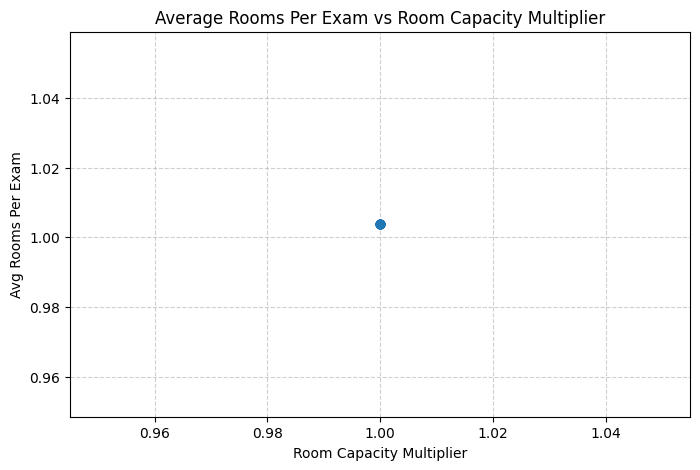

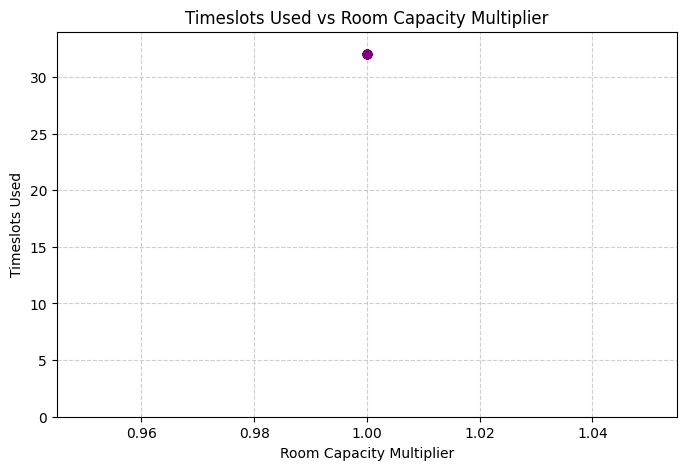

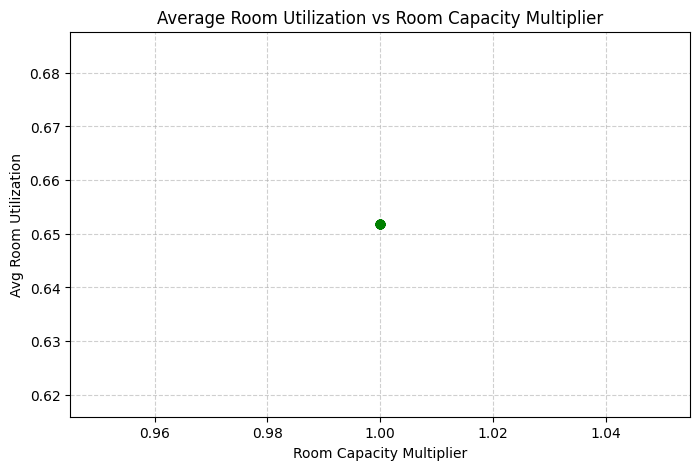

In [12]:
df_plot = df_obj[df_obj["feasible"] == True].copy()

# Plot 1: Avg Rooms Per Exam
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_rooms_per_exam"], marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 2: Timeslots Used
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["timeslots_used"], marker='o', color="purple", linewidth=2)
plt.title("Timeslots Used vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Timeslots Used")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, max(df_plot["timeslots_used"])+2)
plt.show()

# Plot 3: Avg Room Utilization
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_room_utilization"], marker='o', color="green", linewidth=2)
plt.title("Average Room Utilization vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()